In [17]:
%env LD_LIBRARY_PATH=/home/aiops/yueyang/.mujoco/mujoco210/bin

import numpy as np
import os

env: LD_LIBRARY_PATH=/home/aiops/yueyang/.mujoco/mujoco210/bin


In [18]:
def load_advs(path):
    res = np.load(path, allow_pickle=True).item()
    itr = max(res.keys())
    return res[itr]['adv'].squeeze()

def load_weights(path):
    adv = load_advs(path)
    w = adv - adv.min()
    w = w / w.sum() * w.shape[0]
    return w

def linear_weights(adv):
    w = adv - adv.min()
    w = w / w.sum() * w.shape[0]
    return w

def scale(w, s):
    return np.maximum((w - w.mean())  * s + w.mean(), 0)



In [19]:
import matplotlib.pyplot as plt
import gym


def vis(dist, bins):
  plt.hist(dist, bins=bins)
  plt.show()

# vis(d4rl.qlearning_dataset('hopper-medium-replay-v2'))


In [ ]:
# check seeds and methods
rp = 'weights/hopper-medium-replay-v2_returns.npy'
wp = [
    'weights/doublev_nstep_nstep_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_nstep_1_0.95_cosine_hopper-medium-replay-v2_2.npy',
    # 'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_2.npy',
    'weights/doublev_nstep_nstep_3_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_nstep_3_0.95_cosine_hopper-medium-replay-v2_3.npy',
    'weights/doublev_nstep_gae_3_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_gae_3_0.95_cosine_hopper-medium-replay-v2_2.npy',
    # 'weights/doublev_nstep_nstep_10_0.95_cosine_hopper-medium-replay-v2_1.npy',
    'weights/doublev_nstep_nstep_10_0.95_cosine_hopper-medium-replay-v2_3.npy',
]

returns = np.load(rp)
rw = linear_weights(returns)
vis(rw, 50)
print(rw.mean(), rw.std())

for p in wp:
    print(p)
    adv = load_advs(p)
    w = linear_weights(adv)
    vis(w, 50)
    print(w.mean(), w.std())

    w = scale(w, 10)
    vis(w, 50)
    print(w.mean(), w.std())
    # print(p,'\n', adv[:20].squeeze().round(2))
print(adv.shape[0])



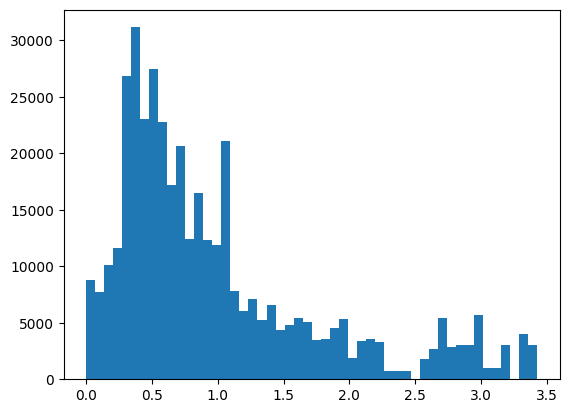

0.9999999427058299 0.8034304826878058
weights/doublev_nstep_nstep_1_0.95_cosine_hopper-medium-replay-v2_1.npy


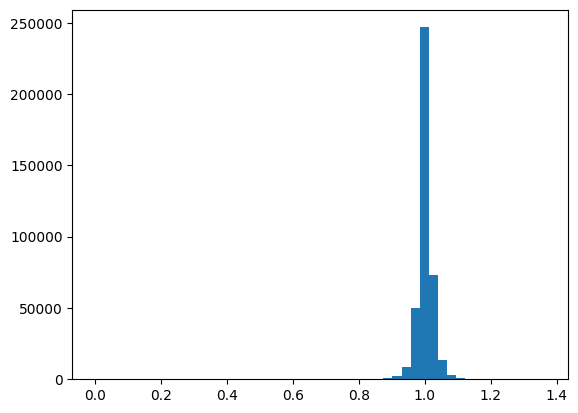

1.0 0.025337498104522856


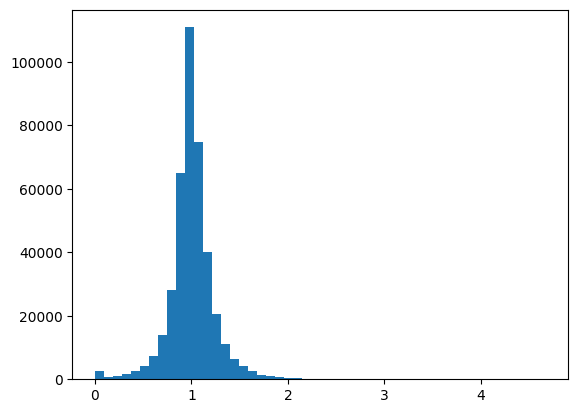

1.0027107941321027 0.23541832682082928
weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_1.npy


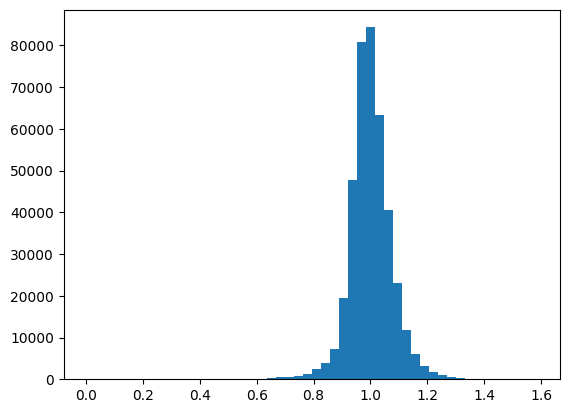

1.0000000000000002 0.07404391094701432


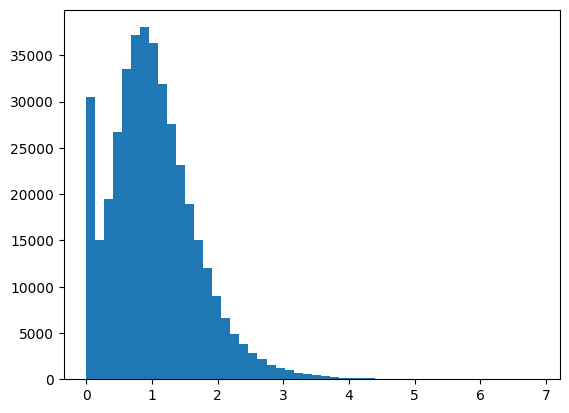

1.0337778636923363 0.6571395067228701
weights/doublev_nstep_nstep_3_0.95_cosine_hopper-medium-replay-v2_1.npy


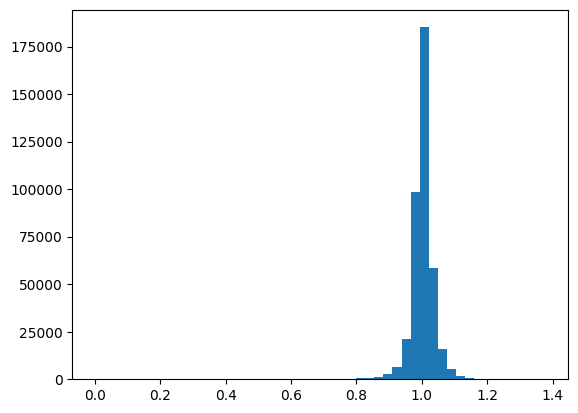

0.9999999250051804 0.04597116435996145


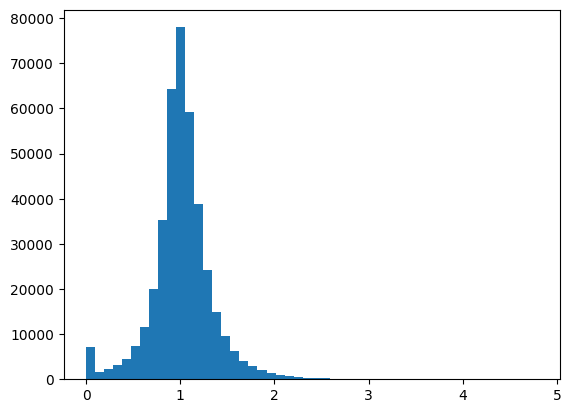

1.0184486229549898 0.32373681733750065
weights/doublev_nstep_gae_3_0.95_cosine_hopper-medium-replay-v2_1.npy


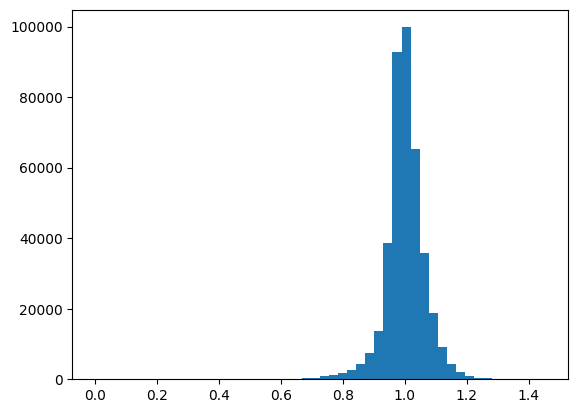

0.9999999999999997 0.06414245123866931


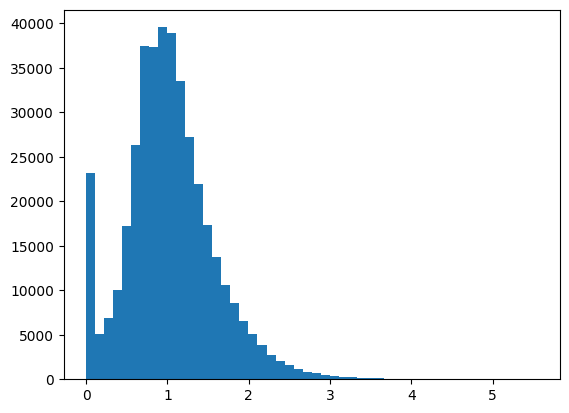

1.0322494572134644 0.5459042924552656
weights/doublev_nstep_nstep_10_0.95_cosine_hopper-medium-replay-v2_3.npy


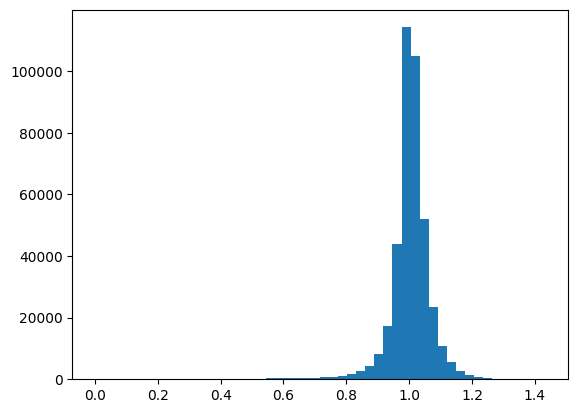

1.0000002770613745 0.0802258303323459


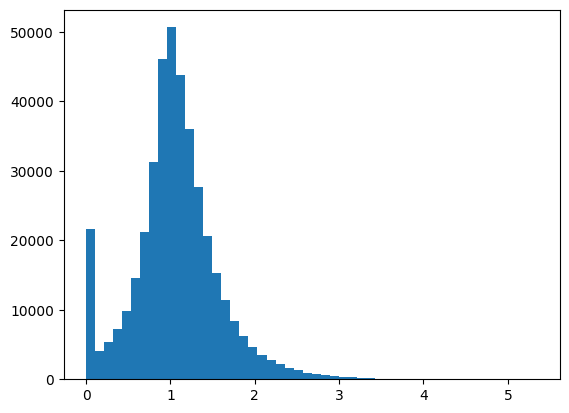

1.0655377160394193 0.5113169243538153
401598


In [22]:
envs = ["hopper-medium-replay-v2", "walker2d-medium-replay-v2",
	"halfcheetah-medium-expert-v2", "hopper-medium-expert-v2"]

for env in envs:
    rp = f'weights/{env}_returns.npy'
    p = f'weights/doublev_nstep_gae_3_0.95_cosine_{env}_1.npy'
    

    returns = np.load(rp)
    rw = linear_weights(returns)
    vis(rw, 50)
    print(rw.mean(), rw.std())

    print(p)
    adv = load_advs(p)
    w = linear_weights(adv)
    vis(w, 50)
    print(w.mean(), w.std())

    w = scale(w, 10)
    vis(w, 50)
    print(w.mean(), w.std())
    # print(p,'\n', adv[:20].squeeze().round(2))
    print(adv.shape[0])



In [21]:
prefix = 'doublev_onestep_cosine'
for env in ['walker2d', 'hopper', 'halfcheetah']:
    for level in ['medium', 'medium-replay', 'medium-expert']:
        task = f'{env}-{level}-v2'
        print(task)
        for seed in range(6):
            path = f"./weights/{prefix}_{task}_{seed}.npy"
            weights = []
            if os.path.exists(path):
                weights.append(load_weights(path))
                print(f'seed {seed}', weights[-1].max().round(2), ' ', weights[-1][:10].round(2))
                idx = int(np.argmax(weights[-1], axis=0))
                print(weights[-1][idx-10:idx+10].round(2))
            else:
                print(f'{path} doesn\'t exists')
            


walker2d-medium-v2
seed 0 1.92   [0.8  0.92 1.03 0.98 0.68 1.14 1.08 1.01 1.02 1.01]
[1.04 1.02 1.01 1.02 1.   0.99 0.98 0.74 1.11 0.67 1.92 1.07 0.97 1.11
 0.9  0.98 1.16 1.05 0.96 1.09]
seed 1 1.89   [0.83 0.97 0.99 0.95 0.7  1.15 0.98 1.11 0.97 0.98]
[1.01 1.03 1.   1.   1.01 0.98 0.96 0.78 1.09 0.67 1.89 1.   1.1  1.03
 0.89 1.05 1.13 1.01 0.96 1.09]
seed 2 1.8   [0.8  0.96 0.99 1.02 0.64 1.17 0.98 1.08 1.01 1.02]
[0.99 0.99 0.99 0.99 0.99 0.99 0.83 0.94 0.82 0.92 1.8  1.07 0.81 1.16
 1.01 0.56 0.99 1.11 1.23 0.97]
seed 3 1.94   [0.81 0.93 0.96 0.92 0.72 1.19 1.03 1.09 1.01 0.99]
[1.04 1.02 1.08 1.01 0.99 0.99 0.72 0.55 0.81 1.12 1.94 1.14 0.76 0.9
 0.93 0.83 1.03 1.13 0.91 1.01]
seed 4 1.92   [0.79 0.94 1.   0.93 0.65 1.19 1.01 1.16 0.97 0.95]
[0.99 0.99 0.99 0.99 0.99 0.99 0.82 0.92 0.77 0.96 1.92 1.04 0.76 1.21
 1.02 0.46 1.05 1.14 1.2  1.11]
seed 5 1.93   [0.77 0.98 1.   0.92 0.72 1.16 1.   1.11 1.01 0.96]
[1.02 1.01 0.99 1.03 1.01 0.96 1.01 0.78 1.07 0.71 1.93 1.01 1.02 1.06
 

KeyboardInterrupt: 